# --- Import packages and create a spark session ---

In [1]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, regexp_extract, avg, round
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import squarify

/var/folders/1q/r_646xk57qd880jhpl1xmnrw0000gn/T/ipykernel_1583/660672066.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#### Create a SparkSession

In [2]:
spark = SparkSession.builder.appName("titanic_spark").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/16 09:22:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# --- Load data ---

#### Read the datasets

In [3]:
train = spark.read.csv("./data/train.csv", header=True, inferSchema=True)
test = spark.read.csv("./data/test.csv", header=True, inferSchema=True)

In [4]:
train.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| NULL|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| NULL|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+------

In [5]:
test.show(5)

+-----------+------+--------------------+------+----+-----+-----+-------+-------+-----+--------+
|PassengerId|Pclass|                Name|   Sex| Age|SibSp|Parch| Ticket|   Fare|Cabin|Embarked|
+-----------+------+--------------------+------+----+-----+-----+-------+-------+-----+--------+
|        892|     3|    Kelly, Mr. James|  male|34.5|    0|    0| 330911| 7.8292| NULL|       Q|
|        893|     3|Wilkes, Mrs. Jame...|female|47.0|    1|    0| 363272|    7.0| NULL|       S|
|        894|     2|Myles, Mr. Thomas...|  male|62.0|    0|    0| 240276| 9.6875| NULL|       Q|
|        895|     3|    Wirz, Mr. Albert|  male|27.0|    0|    0| 315154| 8.6625| NULL|       S|
|        896|     3|Hirvonen, Mrs. Al...|female|22.0|    1|    1|3101298|12.2875| NULL|       S|
+-----------+------+--------------------+------+----+-----+-----+-------+-------+-----+--------+
only showing top 5 rows



#### Explain the dataset
Survived: 0 (No) - 1 (Yes)

Pclass: 1 - 2 - 3 (Ticket class)

SibSp: (Number of siblings/spouses aboard the Titanic)

Parch: (Number of childer aboard the Titanic)

Ticket: (Ticket number)

Fare: (Passenger fare)

Cabin: (Cabin number)

Embarked: C (Cherbourg) - S (Southampton) - Q (Queenstown) (Port of embarkation)

# --- Preprocess data ---

### 1. Preprocess for the train dataset

#### Summary statistics for the train dataset

In [6]:
train.describe().toPandas()

24/04/16 09:22:53 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,summary,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,count,891,891,891,891,891,714,891,891,891,891,204,889
1,mean,446.0,0.3838383838383838,2.308641975308642,None,None,29.69911764705882,0.5230078563411896,0.38159371492704824,260318.54916792738,32.2042079685746,None,None
2,stddev,257.3538420152301,0.48659245426485753,0.8360712409770491,None,None,14.526497332334035,1.1027434322934315,0.8060572211299488,471609.26868834975,49.69342859718089,None,None
3,min,1,0,1,"""Andersson, Mr. August Edvard (""""Wennerstrom"""")""",female,0.42,0,0,110152,0.0,A10,C
4,max,891,1,3,"van Melkebeke, Mr. Philemon",male,80.0,8,6,WE/P 5735,512.3292,T,S


In [7]:
train.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



#### Count the number of missing values in each column

In [8]:
train.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in train.columns]).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,0,0,0,0,177,0,0,0,0,687,2


#### Check the total number of rows in the train dataset

In [9]:
train.count()

891

#### There are a lot of NULL values in the Cabin column, so I decided to drop this column.

In [10]:
train = train.drop("Cabin")

#### Check NULL values for the Embarked column in the train dataset

In [11]:
train.where(col("Embarked").isNull()).show()

+-----------+--------+------+--------------------+------+----+-----+-----+------+----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|Ticket|Fare|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+------+----+--------+
|         62|       1|     1| Icard, Miss. Amelie|female|38.0|    0|    0|113572|80.0|    NULL|
|        830|       1|     1|Stone, Mrs. Georg...|female|62.0|    0|    0|113572|80.0|    NULL|
+-----------+--------+------+--------------------+------+----+-----+-----+------+----+--------+



#### Find the most frequent value for the Embarked column in the train dataset

In [12]:
train.groupBy("Embarked").count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|    NULL|    2|
|       C|  168|
|       S|  644|
+--------+-----+



#### Replace the NULL value in the Embarked column with the most frequent value

In [13]:
train = train.na.fill("S", subset=["Embarked"])

#### Find the title in the Name column

In [14]:
train = train.withColumn("Title", regexp_extract(col("Name"), "([A-Za-z]+)\.", 1))
train.groupBy("Title").count().show()

+--------+-----+
|   Title|count|
+--------+-----+
|     Don|    1|
|    Miss|  182|
|Countess|    1|
|     Col|    2|
|     Rev|    6|
|    Lady|    1|
|  Master|   40|
|     Mme|    1|
|    Capt|    1|
|      Mr|  517|
|      Dr|    7|
|     Mrs|  125|
|     Sir|    1|
|Jonkheer|    1|
|    Mlle|    2|
|   Major|    2|
|      Ms|    1|
+--------+-----+



#### Check each Title to find the appropriate Title for replacing

In [15]:
train.where(col("Title") == 'Don').show()

+-----------+--------+------+--------------------+----+----+-----+-----+--------+-------+--------+-----+
|PassengerId|Survived|Pclass|                Name| Sex| Age|SibSp|Parch|  Ticket|   Fare|Embarked|Title|
+-----------+--------+------+--------------------+----+----+-----+-----+--------+-------+--------+-----+
|         31|       0|     1|Uruchurtu, Don. M...|male|40.0|    0|    0|PC 17601|27.7208|       C|  Don|
+-----------+--------+------+--------------------+----+----+-----+-----+--------+-------+--------+-----+



#### -> Change 'Don' title to 'Mr'

In [16]:
train.where(col("Title") == 'Countess').show()

+-----------+--------+------+--------------------+------+----+-----+-----+------+----+--------+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|Ticket|Fare|Embarked|   Title|
+-----------+--------+------+--------------------+------+----+-----+-----+------+----+--------+--------+
|        760|       1|     1|Rothes, the Count...|female|33.0|    0|    0|110152|86.5|       S|Countess|
+-----------+--------+------+--------------------+------+----+-----+-----+------+----+--------+--------+



#### -> Change 'Countess' title to Ms

In [17]:
train.where(col("Title") == 'Col').show()

+-----------+--------+------+--------------------+----+----+-----+-----+------+-----+--------+-----+
|PassengerId|Survived|Pclass|                Name| Sex| Age|SibSp|Parch|Ticket| Fare|Embarked|Title|
+-----------+--------+------+--------------------+----+----+-----+-----+------+-----+--------+-----+
|        648|       1|     1|Simonius-Blumer, ...|male|56.0|    0|    0| 13213| 35.5|       C|  Col|
|        695|       0|     1|     Weir, Col. John|male|60.0|    0|    0|113800|26.55|       S|  Col|
+-----------+--------+------+--------------------+----+----+-----+-----+------+-----+--------+-----+



#### -> Change 'Col' title to 'Mr'

In [18]:
train.where(col("Title") == 'Rev').show()

+-----------+--------+------+--------------------+----+----+-----+-----+-----------+------+--------+-----+
|PassengerId|Survived|Pclass|                Name| Sex| Age|SibSp|Parch|     Ticket|  Fare|Embarked|Title|
+-----------+--------+------+--------------------+----+----+-----+-----+-----------+------+--------+-----+
|        150|       0|     2|Byles, Rev. Thoma...|male|42.0|    0|    0|     244310|  13.0|       S|  Rev|
|        151|       0|     2|Bateman, Rev. Rob...|male|51.0|    0|    0|S.O.P. 1166|12.525|       S|  Rev|
|        250|       0|     2|Carter, Rev. Erne...|male|54.0|    1|    0|     244252|  26.0|       S|  Rev|
|        627|       0|     2|Kirkland, Rev. Ch...|male|57.0|    0|    0|     219533| 12.35|       Q|  Rev|
|        849|       0|     2|   Harper, Rev. John|male|28.0|    0|    1|     248727|  33.0|       S|  Rev|
|        887|       0|     2|Montvila, Rev. Ju...|male|27.0|    0|    0|     211536|  13.0|       S|  Rev|
+-----------+--------+------+--------

#### -> Change 'Rev' title to 'Mr'

In [19]:
train.where(col("Title") == 'Mme').show()

+-----------+--------+------+--------------------+------+----+-----+-----+--------+----+--------+-----+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|  Ticket|Fare|Embarked|Title|
+-----------+--------+------+--------------------+------+----+-----+-----+--------+----+--------+-----+
|        370|       1|     1|Aubart, Mme. Leon...|female|24.0|    0|    0|PC 17477|69.3|       C|  Mme|
+-----------+--------+------+--------------------+------+----+-----+-----+--------+----+--------+-----+



#### -> Change 'Mme' title to 'Ms'

In [20]:
train.where(col("Title") == 'Capt').show()

+-----------+--------+------+--------------------+----+----+-----+-----+---------+----+--------+-----+
|PassengerId|Survived|Pclass|                Name| Sex| Age|SibSp|Parch|   Ticket|Fare|Embarked|Title|
+-----------+--------+------+--------------------+----+----+-----+-----+---------+----+--------+-----+
|        746|       0|     1|Crosby, Capt. Edw...|male|70.0|    1|    1|WE/P 5735|71.0|       S| Capt|
+-----------+--------+------+--------------------+----+----+-----+-----+---------+----+--------+-----+



#### -> Change 'Capt' title to 'Mr'

In [21]:
train.where(col("Title") == 'Jonkheer').show()

+-----------+--------+------+--------------------+----+----+-----+-----+------+----+--------+--------+
|PassengerId|Survived|Pclass|                Name| Sex| Age|SibSp|Parch|Ticket|Fare|Embarked|   Title|
+-----------+--------+------+--------------------+----+----+-----+-----+------+----+--------+--------+
|        823|       0|     1|Reuchlin, Jonkhee...|male|38.0|    0|    0| 19972| 0.0|       S|Jonkheer|
+-----------+--------+------+--------------------+----+----+-----+-----+------+----+--------+--------+



#### -> Change 'Jonkheer' title to 'Mr'

In [22]:
train.where(col("Title") == 'Mlle').show()

+-----------+--------+------+--------------------+------+----+-----+-----+--------+-------+--------+-----+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|  Ticket|   Fare|Embarked|Title|
+-----------+--------+------+--------------------+------+----+-----+-----+--------+-------+--------+-----+
|        642|       1|     1|Sagesser, Mlle. Emma|female|24.0|    0|    0|PC 17477|   69.3|       C| Mlle|
|        711|       1|     1|"Mayne, Mlle. Ber...|female|24.0|    0|    0|PC 17482|49.5042|       C| Mlle|
+-----------+--------+------+--------------------+------+----+-----+-----+--------+-------+--------+-----+



#### -> Change 'Mlle' title to 'Ms'

In [23]:
train.where(col("Title") == 'Major').show()

+-----------+--------+------+--------------------+----+----+-----+-----+------+-----+--------+-----+
|PassengerId|Survived|Pclass|                Name| Sex| Age|SibSp|Parch|Ticket| Fare|Embarked|Title|
+-----------+--------+------+--------------------+----+----+-----+-----+------+-----+--------+-----+
|        450|       1|     1|Peuchen, Major. A...|male|52.0|    0|    0|113786| 30.5|       S|Major|
|        537|       0|     1|Butt, Major. Arch...|male|45.0|    0|    0|113050|26.55|       S|Major|
+-----------+--------+------+--------------------+----+----+-----+-----+------+-----+--------+-----+



#### -> Change 'Major' title to 'Mr'

#### Replace misspelling title values

In [24]:
train = train.replace(["Don", "Countess", "Col", "Rev", "Mme", "Capt", "Jonkheer", "Mlle", "Major", "Sir", "Lady"], 
                      ["Mr", "Ms", "Mr", "Mr", "Ms", "Mr", "Mr", "Ms", "Mr", "Mr", "Ms"], 
                      "Title")
train.groupBy("Title").count().show()

+------+-----+
| Title|count|
+------+-----+
|  Miss|  182|
|Master|   40|
|    Mr|  531|
|    Dr|    7|
|   Mrs|  125|
|    Ms|    6|
+------+-----+



#### Check the Title values matching with the Sex values

In [25]:
train.groupBy(["Title", "Sex"]).count().show()

+------+------+-----+
| Title|   Sex|count|
+------+------+-----+
|Master|  male|   40|
|    Dr|  male|    6|
|   Mrs|female|  125|
|  Miss|female|  182|
|    Mr|  male|  531|
|    Dr|female|    1|
|    Ms|female|    6|
+------+------+-----+



#### Calculate the average age for each title

In [26]:
avg_age_df = spark.createDataFrame(train.groupBy(["Title"]).agg(avg("Age").alias("Avg_Age")).toPandas())
avg_age_df = avg_age_df.withColumn("Avg_Age", round(avg_age_df["Avg_Age"]).cast("double"))
avg_age_df.show()

+------+-------+
| Title|Avg_Age|
+------+-------+
|  Miss|   22.0|
|Master|    5.0|
|    Mr|   33.0|
|    Dr|   42.0|
|   Mrs|   36.0|
|    Ms|   30.0|
+------+-------+



#### Replace the NULL values in the Age column with the average values for each Title

In [27]:
for row in avg_age_df.collect():
    train = train.withColumn("Age", when((col("Title") == row["Title"]) & (col("Age").isNull()), row["Avg_Age"]).otherwise(col("Age")))

### Check NULL values in the train dataset

In [28]:
train.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in train.columns]).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,0,0,0,0,0,0,0,0,0,0,0,0


#### Remove unnecessary columns for the analysis

In [29]:
train = train.drop("PassengerId", "Name", "Ticket", "Title")
train.show(5)

+--------+------+------+----+-----+-----+-------+--------+
|Survived|Pclass|   Sex| Age|SibSp|Parch|   Fare|Embarked|
+--------+------+------+----+-----+-----+-------+--------+
|       0|     3|  male|22.0|    1|    0|   7.25|       S|
|       1|     1|female|38.0|    1|    0|71.2833|       C|
|       1|     3|female|26.0|    0|    0|  7.925|       S|
|       1|     1|female|35.0|    1|    0|   53.1|       S|
|       0|     3|  male|35.0|    0|    0|   8.05|       S|
+--------+------+------+----+-----+-----+-------+--------+
only showing top 5 rows



### Preprocess for the test dataset

In [30]:
test.describe().toPandas()

,summary,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,count,418,418,418,418,332,418,418,418,417,91,418
1,mean,1100.5,2.2655502392344498,None,None,30.272590361445783,0.4473684210526316,0.3923444976076555,223850.98986486485,35.6271884892086,None,None
2,stddev,120.81045760473994,0.8418375519640503,None,None,14.181209235624424,0.8967595611217135,0.9814288785371694,369523.7764694362,55.907576179973844,None,None
3,min,892,1,"""Assaf Khalil, Mrs. Mariana (Miriam"""")""""""",female,0.17,0,0,110469,0.0,A11,C
4,max,1309,3,"van Billiard, Master. Walter John",male,76.0,8,9,W.E.P. 5734,512.3292,G6,S


#### Count the number of missing values in each column

In [31]:
test.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in test.columns]).toPandas()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,0,0,0,86,0,0,0,1,327,0


#### Check the total number of rows in the test dataset

In [32]:
test.count()

418

#### Remove the Cabin column due to lots of missing values

In [33]:
test = test.drop("Cabin")
test.show(5)

+-----------+------+--------------------+------+----+-----+-----+-------+-------+--------+
|PassengerId|Pclass|                Name|   Sex| Age|SibSp|Parch| Ticket|   Fare|Embarked|
+-----------+------+--------------------+------+----+-----+-----+-------+-------+--------+
|        892|     3|    Kelly, Mr. James|  male|34.5|    0|    0| 330911| 7.8292|       Q|
|        893|     3|Wilkes, Mrs. Jame...|female|47.0|    1|    0| 363272|    7.0|       S|
|        894|     2|Myles, Mr. Thomas...|  male|62.0|    0|    0| 240276| 9.6875|       Q|
|        895|     3|    Wirz, Mr. Albert|  male|27.0|    0|    0| 315154| 8.6625|       S|
|        896|     3|Hirvonen, Mrs. Al...|female|22.0|    1|    1|3101298|12.2875|       S|
+-----------+------+--------------------+------+----+-----+-----+-------+-------+--------+
only showing top 5 rows



#### Check the row with NULL value in the Fare column for the test dataset

In [34]:
test.where(col("Fare").isNull()).show()

+-----------+------+------------------+----+----+-----+-----+------+----+--------+
|PassengerId|Pclass|              Name| Sex| Age|SibSp|Parch|Ticket|Fare|Embarked|
+-----------+------+------------------+----+----+-----+-----+------+----+--------+
|       1044|     3|Storey, Mr. Thomas|male|60.5|    0|    0|  3701|NULL|       S|
+-----------+------+------------------+----+----+-----+-----+------+----+--------+



#### Replace the NULL value in the Fare column with the average value for Pclass=3, Sex=male, and Embarked=S for the test dataset

In [35]:
avg_fare = test.filter("Pclass=3 and Sex='male' and Embarked='S'").agg({"Fare": "avg"}).collect()[0][0]
test = test.na.fill(avg_fare, subset=["Fare"])

In [36]:
test.where(col("Fare").isNull()).show()

+-----------+------+----+---+---+-----+-----+------+----+--------+
|PassengerId|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Embarked|
+-----------+------+----+---+---+-----+-----+------+----+--------+
+-----------+------+----+---+---+-----+-----+------+----+--------+



#### Find the title in the Name column

In [37]:
test = test.withColumn("Title", regexp_extract(col("Name"), "([A-Za-z]+)\.", 1))
test.groupBy("Title").count().show()

+------+-----+
| Title|count|
+------+-----+
|  Dona|    1|
|  Miss|   78|
|   Col|    2|
|   Rev|    2|
|Master|   21|
|    Mr|  240|
|    Dr|    1|
|   Mrs|   72|
|    Ms|    1|
+------+-----+



In [38]:
test.where(col("Title") == 'Dona').show()

+-----------+------+--------------------+------+----+-----+-----+--------+-----+--------+-----+
|PassengerId|Pclass|                Name|   Sex| Age|SibSp|Parch|  Ticket| Fare|Embarked|Title|
+-----------+------+--------------------+------+----+-----+-----+--------+-----+--------+-----+
|       1306|     1|Oliva y Ocana, Do...|female|39.0|    0|    0|PC 17758|108.9|       C| Dona|
+-----------+------+--------------------+------+----+-----+-----+--------+-----+--------+-----+



#### -> Change the 'Dona' title to 'Ms'

In [39]:
test.where(col("Title") == 'Col').show()

+-----------+------+--------------------+----+----+-----+-----+--------+-------+--------+-----+
|PassengerId|Pclass|                Name| Sex| Age|SibSp|Parch|  Ticket|   Fare|Embarked|Title|
+-----------+------+--------------------+----+----+-----+-----+--------+-------+--------+-----+
|       1023|     1|Gracie, Col. Arch...|male|53.0|    0|    0|  113780|   28.5|       C|  Col|
|       1094|     1|Astor, Col. John ...|male|47.0|    1|    0|PC 17757|227.525|       C|  Col|
+-----------+------+--------------------+----+----+-----+-----+--------+-------+--------+-----+



#### -> Change the 'Col' title to 'Mr'

In [40]:
test.where(col("Title") == 'Rev').show()

+-----------+------+--------------------+----+----+-----+-----+------+----+--------+-----+
|PassengerId|Pclass|                Name| Sex| Age|SibSp|Parch|Ticket|Fare|Embarked|Title|
+-----------+------+--------------------+----+----+-----+-----+------+----+--------+-----+
|       1041|     2|Lahtinen, Rev. Wi...|male|30.0|    1|    1|250651|26.0|       S|  Rev|
|       1056|     2|Peruschitz, Rev. ...|male|41.0|    0|    0|237393|13.0|       S|  Rev|
+-----------+------+--------------------+----+----+-----+-----+------+----+--------+-----+



#### -> Change the 'Rev' title to 'Mr'

In [41]:
test.where(col("Title") == 'Dr').show()

+-----------+------+--------------------+----+----+-----+-----+------+-------+--------+-----+
|PassengerId|Pclass|                Name| Sex| Age|SibSp|Parch|Ticket|   Fare|Embarked|Title|
+-----------+------+--------------------+----+----+-----+-----+------+-------+--------+-----+
|       1185|     1|Dodge, Dr. Washin...|male|53.0|    1|    1| 33638|81.8583|       S|   Dr|
+-----------+------+--------------------+----+----+-----+-----+------+-------+--------+-----+



#### -> Change the 'Dr' title to 'Mr'

#### Replace misspelling title values

In [42]:
test = test.replace(["Dona", "Col", "Rev", "Dr"], 
                    ["Ms", "Mr", "Mr", "Mr"], 
                    "Title")
test.groupBy("Title").count().show()

+------+-----+
| Title|count|
+------+-----+
|  Miss|   78|
|Master|   21|
|    Mr|  245|
|   Mrs|   72|
|    Ms|    2|
+------+-----+



#### Check the Title values matching the the Sex values

In [43]:
test.groupBy(["Title", "Sex"]).count().show()

+------+------+-----+
| Title|   Sex|count|
+------+------+-----+
|Master|  male|   21|
|   Mrs|female|   72|
|  Miss|female|   78|
|    Mr|  male|  245|
|    Ms|female|    2|
+------+------+-----+



#### Calculate the average values for each title

In [44]:
avg_age_df_test = spark.createDataFrame(test.groupBy(["Title"]).agg(avg("Age").alias("Avg_Age")).toPandas())
avg_age_df_test = avg_age_df_test.withColumn("Avg_Age", round(avg_age_df_test["Avg_Age"]).cast("double"))
avg_age_df_test.show()

+------+-------+
| Title|Avg_Age|
+------+-------+
|  Miss|   22.0|
|Master|    7.0|
|    Mr|   32.0|
|   Mrs|   39.0|
|    Ms|   39.0|
+------+-------+



#### Replace the NULL values in the Age column with the average age for each title

In [45]:
for row in avg_age_df_test.collect():
    test = test.withColumn("Age", when((col("Title") == row["Title"]) & (col("Age").isNull()), row["Avg_Age"]).otherwise(col("Age")))

#### Check NULL values in the test dataset

In [46]:
test.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in test.columns]).toPandas()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,0,0,0,0,0,0,0,0,0,0,0


#### Remove unnecessary columns for the analysis

In [47]:
test = test.drop("PassengerId", "Name", "Ticket", "Title")
test.show(5)

+------+------+----+-----+-----+-------+--------+
|Pclass|   Sex| Age|SibSp|Parch|   Fare|Embarked|
+------+------+----+-----+-----+-------+--------+
|     3|  male|34.5|    0|    0| 7.8292|       Q|
|     3|female|47.0|    1|    0|    7.0|       S|
|     2|  male|62.0|    0|    0| 9.6875|       Q|
|     3|  male|27.0|    0|    0| 8.6625|       S|
|     3|female|22.0|    1|    1|12.2875|       S|
+------+------+----+-----+-----+-------+--------+
only showing top 5 rows



# --- Exploratory Data Analysis ---

In [48]:
df_train = train.toPandas()

In [49]:
sns.set_theme(rc={'axes.facecolor':'#dedad2', 'figure.facecolor':'#d7e1ee'})

#### 1. Explore feature 'Pclass'

In [50]:
# Show the percentage of each category in the feature
def percentage_with_hue(plot, feature, number_of_categories, hue_categories):
    patch = [p for p in plot.patches]
    ind = 0
    for i in range(number_of_categories):
        for j in range(hue_categories):
            x = patch[(j*number_of_categories + i)].get_x() + patch[(j*number_of_categories + i)].get_width() / 2 - 0.1
            y = patch[(j*number_of_categories + i)].get_y() + patch[(j*number_of_categories + i)].get_height()
            plot.annotate('{:.2f}%'.format(feature[ind]), (x, y), size = 10)
            ind += 1
    plt.show()

In [ ]:
# Show the percentage in the feature without category
def percentage_without_hue(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        plot.annotate(percentage, (x, y), size = 12)
    plt.show()

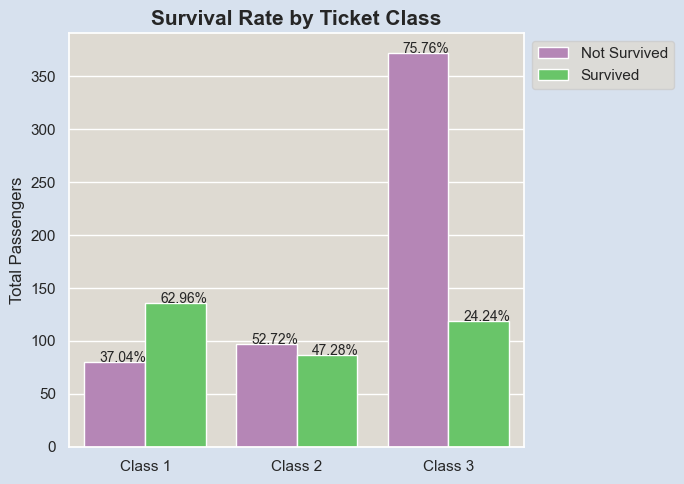

In [51]:
df_pclass = df_train.groupby(['Pclass', 'Survived']).size().reset_index()
df_pclass.rename(columns={0: 'Count'}, inplace=True)
df_pclass['Percentage'] = df_train.groupby(['Pclass', 'Survived']).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).values
df_pclass['PclassLabel'] = np.where(df_pclass['Pclass'] == 1, 'Class 1', np.where(df_pclass['Pclass'] == 2, 'Class 2', 'Class 3'))
df_pclass['SurvivedLabel'] = np.where(df_pclass['Survived'] == 0, 'Not Survived', 'Survived')

# Plotting with Seaborn
plt.figure(figsize=(7, 5))
ax = sns.barplot(data=df_pclass, x='PclassLabel', y='Count', hue='SurvivedLabel', palette=["#bd7ebe", "#5ad45a"])
plt.title('Survival Rate by Ticket Class', fontsize=15, fontweight='bold')
plt.legend(title='', loc='upper left')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel('')
plt.ylabel('Total Passengers')
plt.tight_layout()
percentage_with_hue(ax, df_pclass['Percentage'], 3, 2)

##### Class 3 had the highest number of passengers. It also indicated that the number of passengers died in Class 3 was significantly higher than other classes. Class 1 had the highest number of survival passengers followed by Class 3 and Class 2.

#### 2. Explore features 'SibSp'

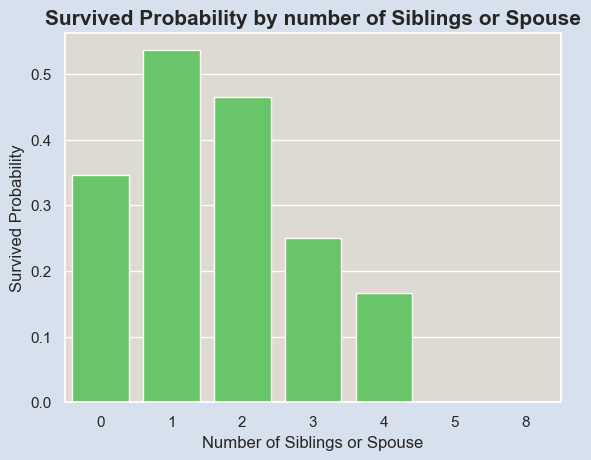

In [52]:
# Calculate survival rates
survival_rates = df_train.groupby('SibSp')['Survived'].mean().reset_index()

# Create bar plot using Seaborn
ax = sns.barplot(data=survival_rates, x='SibSp', y='Survived', color="#5ad45a")
plt.title("Survived Probability by number of Siblings or Spouse", fontsize=15, fontweight='bold')
plt.xlabel("Number of Siblings or Spouse")
plt.ylabel("Survived Probability")
# Show plot
plt.show()

##### There was a maximum of 8 siblings and spouses traveled along with one of the passenger. With passengers having one sibling or spouse, the survived probability was more than 50%. Passengers traveling with 2 siblings or spouse had the survived probability nearly 50%. The chances of survival dropped drastically if someone traveled with more than 2 siblings or spouse.

#### 3. Explore feature 'Parch'

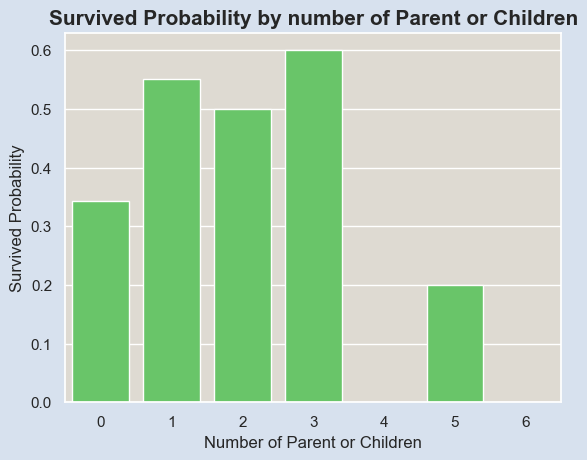

In [53]:
# Calculate survival rates
survival_rates = df_train.groupby('Parch')['Survived'].mean().reset_index()

# Create bar plot using Seaborn
sns.barplot(data=survival_rates, x='Parch', y='Survived', color="#5ad45a")
plt.title("Survived Probability by number of Parent or Children", fontsize=15, fontweight='bold')
plt.xlabel("Number of Parent or Children")
plt.ylabel("Survived Probability")

# Show plot
plt.show()

##### Passengers traveled with 1 to 3 Parent or Children had the chance of survival more than 50%, especially with the highest probability for 3 Parent or Children at 60%. With passenger traveled alone, the chance of survival was 34% while the survived probability for 5 Parent or Children was 20%. There was no chance of survival for passengers traveled with 4 or 6 Parent or Children.

#### 4. Explore feature 'Fare'

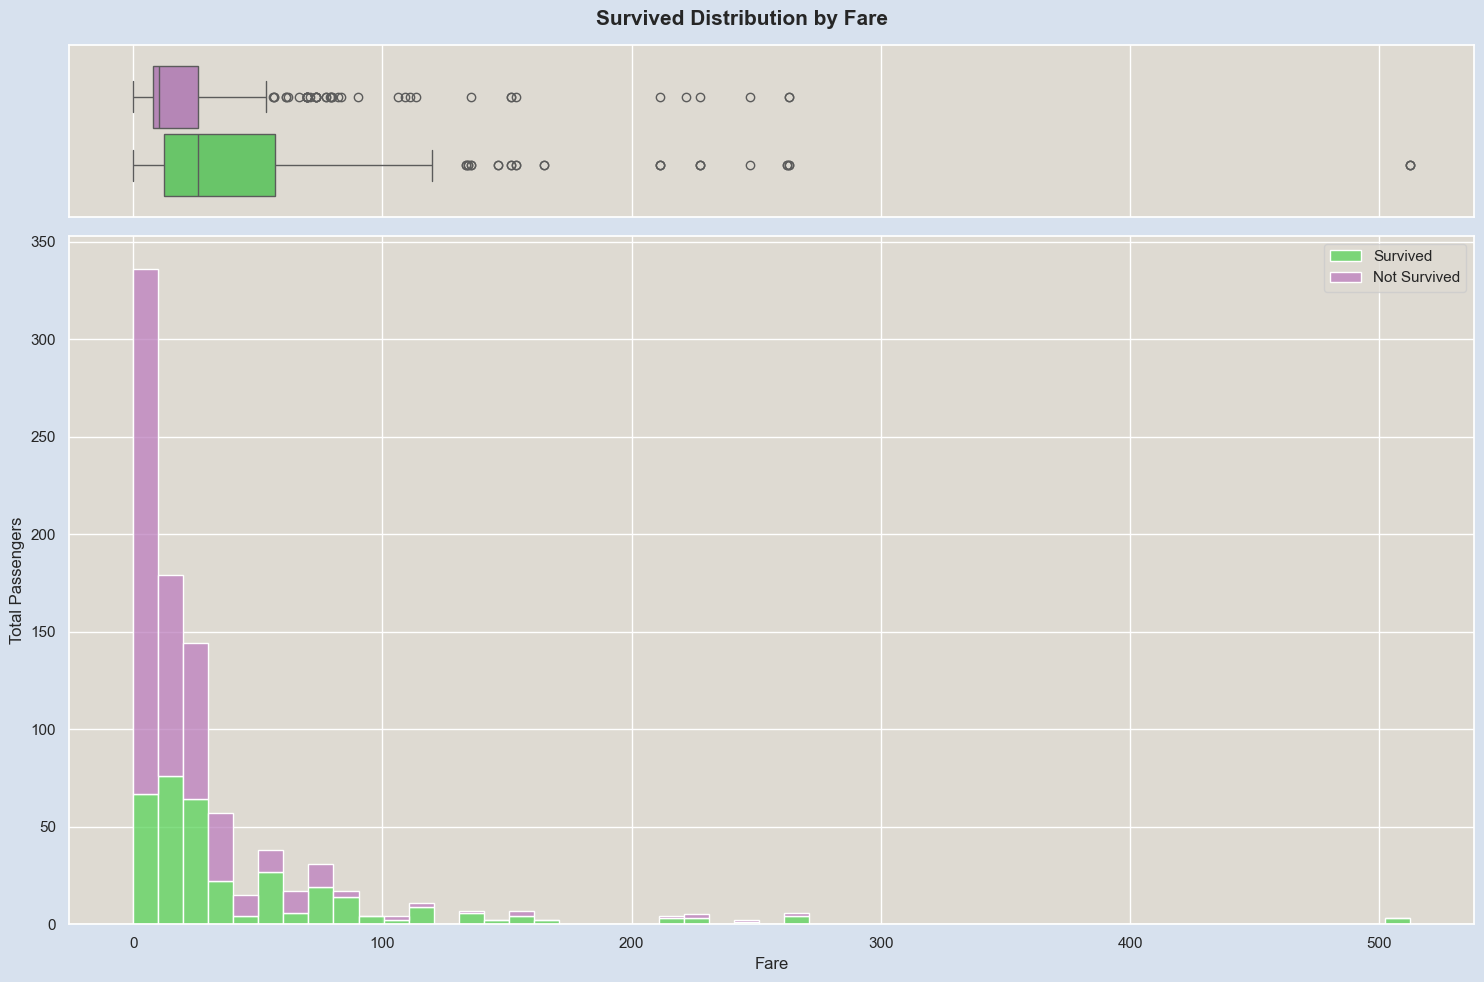

In [54]:
fig, (axbox, axhist) = plt.subplots(ncols=1, nrows=2, figsize=(15, 10), sharex=True, gridspec_kw={"height_ratios": (.2, .8)})
fig.suptitle('Survived Distribution by Fare', fontsize=15, fontweight='bold')

# Create boxplot
sns.boxplot(x='Fare', data=df_train, palette=["#bd7ebe", "#5ad45a"], hue='Survived', ax= axbox, gap=.1)

# Create histogram
ax = sns.histplot(data=df_train, x="Fare", hue="Survived", multiple="stack",
            palette=["#bd7ebe", "#5ad45a"], binwidth=10, ax=axhist)

plt.xlabel("Fare")
plt.ylabel("Total Passengers")
plt.legend(loc='upper right', labels=['Survived', 'Not Survived'])
ax.legend_.set_title(None)
axbox.legend_.remove()
fig.tight_layout()
plt.show()

##### There was a strong association between the fare and the survival. The dispersion of survival for passengers paid more money was wider than the dispersion of death. There were some outliers for passengers paid more money but still not survived. The higher the passengers paid, the higher would be their chances to survive.

#### 5. Explore feature 'Age'

In [55]:
def modify_agegroup(age):
    if age <= 10:
        return "0-10"
    elif age <= 20 and age > 10:
        return "11-20"
    elif age <= 30 and age > 20:
        return "21-30"
    elif age <=40 and age > 30:
        return "31-40"
    elif age <= 50 and age > 40:
        return "41-50"
    elif age <= 60 and age > 50:
        return "51-60"
    elif age <= 70 and age > 60:
        return "61-70"
    else:
        return "71+"

In [56]:
df_train['AgeGroup'] = df_train.apply(lambda x: modify_agegroup(x['Age']), axis=1)

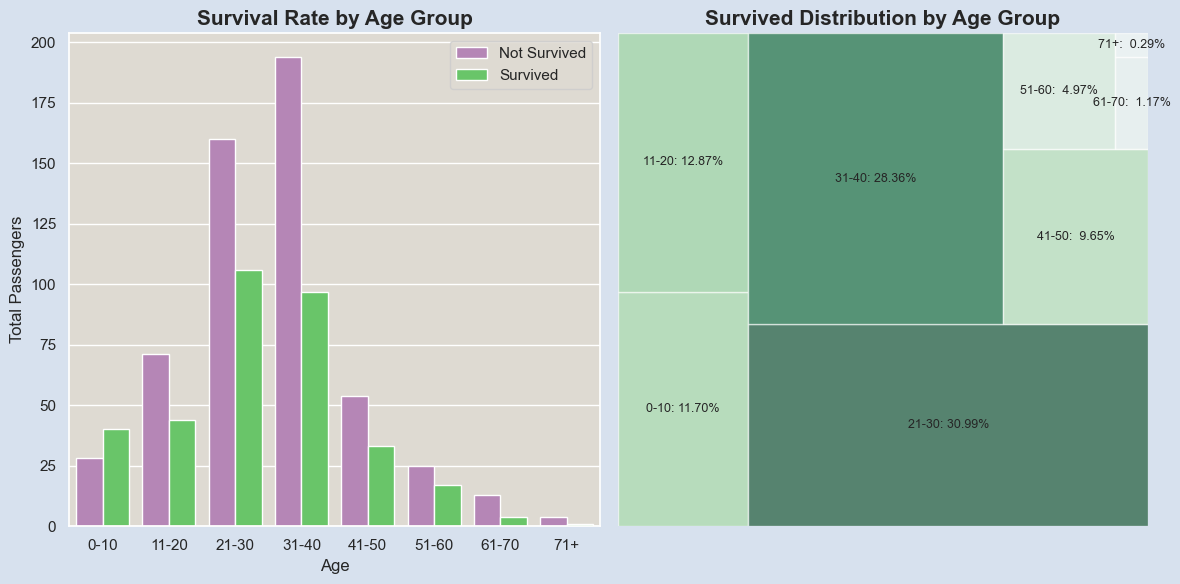

In [57]:
df_age = df_train.groupby(['AgeGroup', 'Survived']).size().reset_index()
df_age.rename(columns={0: 'Count'}, inplace=True)

plt.figure(figsize=(12, 6))

# Create grouped barplot
plt.subplot(1, 2, 1)
labels_barplot = ['Not Survived', 'Survived']
ax = sns.barplot(data=df_age, x='AgeGroup', y='Count', hue='Survived', palette=["#bd7ebe", "#5ad45a"])
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels_barplot, title='', loc='upper right')
plt.title('Survival Rate by Age Group', fontsize=15, fontweight='bold')
plt.xlabel('Age')
plt.ylabel('Total Passengers')

# Create treemap
plt.subplot(1, 2, 2)
# Change relative colors based on the number of survived passengers
cmap = matplotlib.cm.Greens
mini=min(df_age[df_age['Survived'] == 1]['Count'])
maxi=max(df_age[df_age['Survived'] == 1]['Count'])
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in df_age[df_age['Survived'] == 1]['Count']]
# Display the percentage of survived passengers in each age group
perc_survived = [f'{i/df_age[df_age["Survived"] == 1]["Count"].sum()*100:5.2f}%' for i in df_age[df_age['Survived'] == 1]['Count']]
labels_treemap = [f'{df_age[df_age["Survived"] == 1]["AgeGroup"].iloc[i]}: {perc_survived[i]}' for i in range(len(df_age[df_age['Survived'] == 1]))]
squarify.plot(sizes=df_age[df_age['Survived'] == 1]['Count'], label=labels_treemap, 
              alpha=.6, color=colors, text_kwargs={'fontsize':9})
plt.title('Survived Distribution by Age Group', fontsize=15, fontweight='bold')
plt.axis('off')

plt.tight_layout()
plt.show()

##### The change of survival for passengers with age below 10 compared to not survival was significantly higher than other groups. The most passengers onboard in between 21 to 40 year-old, and the chance of survival for these groups was nearly equal the death. Based on the survived group, the age between 21 and 30 had the rate of survival higher than the other groups at 30.99%, and follow by the age between 31 and 40 at 28.36%. With older passengers over 60 year olds, the chance of survival was low.

#### 6. Explore feature 'Sex'

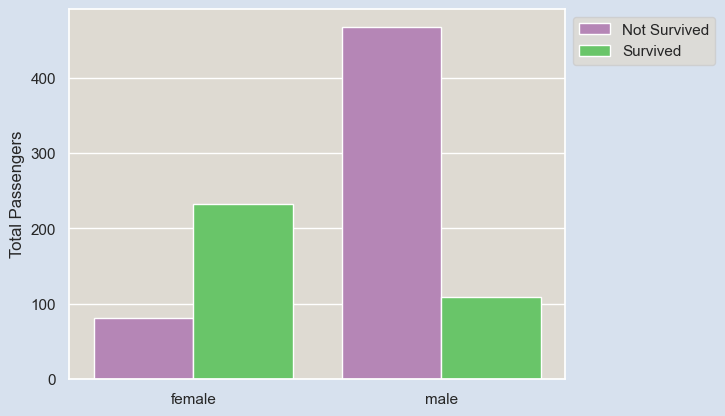

In [58]:
df_gender = df_train.groupby(['Sex', 'Survived']).size().reset_index()
df_gender.rename(columns={0: 'Count'}, inplace=True)

ax = sns.barplot(data=df_gender, x='Sex', y='Count', hue='Survived', palette=["#bd7ebe", "#5ad45a"])
labels_barplot = ['Not Survived', 'Survived']
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels_barplot, title='', loc='upper left')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel('')
plt.ylabel('Total Passengers')

plt.show()

In [ ]:
# The relationship between gender and age for the chance of survival
df_gender_age = df_train.groupby(['Sex', 'AgeGroup', 'Survived']).size().reset_index()
df_gender_age.rename(columns={0: 'Count'}, inplace=True)
graph = sns.FacetGrid(df_gender_age, row='Sex', hue='Survived', height=5, aspect=1.5, palette=["#bd7ebe", "#5ad45a"])
graph.map(sns.barplot, 'AgeGroup', 'Count')
plt.show()